<a href="https://colab.research.google.com/github/apu754/Trabajo1IA/blob/main/IA2_vgsales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA2 (2025-2) — Regresión con *Video Game Sales* (Kaggle)
## MLP (Keras) + Ensembles + K-Fold + GridSearch + **Probabilidad de “mejor modelo”** (bootstrap)

**Integrantes (cédulas):** 00000000000, 11111111111, 2222222222, 3333333333  
**Target:** `Global_Sales` (en **millones**)  
**Features (sin fuga de información):** `Platform`, `Year`, `Genre`, `Publisher`  

### Checklist (1–10)
1) Dataset de Kaggle (regresión), variables y correlación  
2) **EDA**: limpieza (NULL), outliers (IQR), **balanceo** por bins  
3) **MLP** (Keras) — 3 arquitecturas  
4) Ensamble con Keras (cubre MLP) y **Ensemble Learning** (RF/GB/ET)  
5) **Ensembles** con 3 configuraciones (GridSearch)  
6) **Split** por complemento de cédula (promedio últimos 2 dígitos)  
7) Entrenamiento MLP con **MSE** como *loss* y métrica (logs **verbose=1**)  
8) Comparar **6 modelos** con MSE/MAE/R² y **K-Fold**  
9) Evaluar en **Test** antes de CV  
10) **GridSearchCV** para el mejor modelo  

> Además: **probabilidad de que un modelo sea mejor** (menor MSE en Test) usando **bootstrap** de diferencias emparejadas.
s


In [ ]:
# !pip install -q numpy pandas matplotlib scikit-learn tensorflow

## 1) Imports y utilidades

In [ ]:
import os, json, math, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


## 2) Cargar dataset `vgsales.csv` y explorar variables
- Objetivo: **`Global_Sales`** (millones)
- Features (sin leakage): **`Platform`, `Year`, `Genre`, `Publisher`**
- Se evita usar `NA_Sales/EU_Sales/JP_Sales/Other_Sales` porque su suma ≈ `Global_Sales`.

In [ ]:
csv_path = "/content/vgsales.csv"

df = pd.read_csv(csv_path)
display(df.head())
display({'shape': df.shape})
df.info()

display({'nulos_post_limpieza': df.isna().sum().to_dict()})
display(df.head())

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


{'shape': (16598, 11)}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


{'nulos_post_limpieza': {'Rank': 0,
  'Name': 0,
  'Platform': 0,
  'Year': 271,
  'Genre': 0,
  'Publisher': 58,
  'NA_Sales': 0,
  'EU_Sales': 0,
  'JP_Sales': 0,
  'Other_Sales': 0,
  'Global_Sales': 0}}

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 3) Limpieza: `Year` numérico, NULL y 3 técnicas
1. **Eliminar** filas sin `Global_Sales`  
2. **Imputar** `Year` por mediana por grupo (`Platform`,`Genre`) y luego mediana global  
3. **Relleno** en categóricas con `'Unknown'`  
Además, `Year` → numérico (convierte `'N/A'` a `NaN`).

In [ ]:
df_clean = df.copy()
if 'Year' in df_clean.columns:
    df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')

target_col = 'Global_Sales'
core_feats = ['Platform','Year','Genre','Publisher']
for col in [target_col]+core_feats:
    if col not in df_clean.columns:
        raise ValueError(f'Falta la columna {col} en el dataset')

# 1) eliminar si falta el target
df_clean = df_clean.dropna(subset=[target_col])

# 2) imputar Year
grp_med = df_clean.groupby(['Platform','Genre'])['Year'].transform(lambda s: s.fillna(s.median()))
df_clean['Year'] = df_clean['Year'].fillna(grp_med)
df_clean['Year'] = df_clean['Year'].fillna(df_clean['Year'].median())

# 3) categóricas a 'Unknown'
for c in ['Platform','Genre','Publisher']:
    df_clean[c] = df_clean[c].fillna('Unknown')

display({'nulos_post_limpieza': df_clean.isna().sum().to_dict()})
display(df_clean.head())

{'nulos_post_limpieza': {'Rank': 0,
  'Name': 0,
  'Platform': 0,
  'Year': 0,
  'Genre': 0,
  'Publisher': 0,
  'NA_Sales': 0,
  'EU_Sales': 0,
  'JP_Sales': 0,
  'Other_Sales': 0,
  'Global_Sales': 0}}

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


## 4) EDA: correlación, distribución y outliers (IQR)
No usamos ventas regionales como features, pero se puede mostrar correlación entre numéricas por referencia.

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,1.000,0.180,-0.401,-0.379,-0.268,-0.333,-0.427
Year,0.180,1.000,-0.092,0.006,-0.167,0.041,-0.075
NA_Sales,-0.401,-0.092,1.000,0.768,0.450,0.635,0.941
EU_Sales,-0.379,0.006,0.768,1.000,0.436,0.726,0.903
JP_Sales,-0.268,-0.167,0.450,0.436,1.000,0.290,0.612
Other_Sales,-0.333,0.041,0.635,0.726,0.290,1.000,0.748
Global_Sales,-0.427,-0.075,0.941,0.903,0.612,0.748,1.000


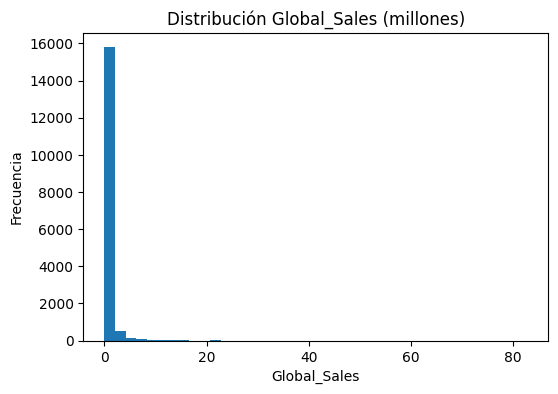

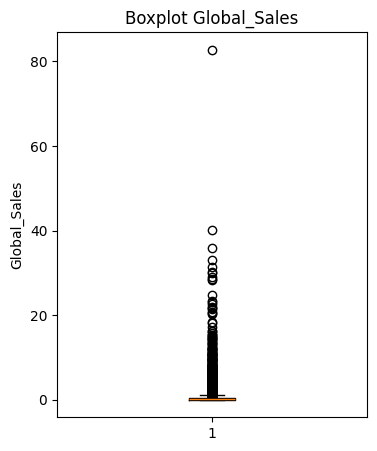

{'Q1': np.float64(0.06),
 'Q3': np.float64(0.47),
 'IQR': np.float64(0.41),
 'UpperFence': np.float64(1.085),
 'OutlierCount': 1893}

In [ ]:
num_cols = [c for c in df_clean.columns if pd.api.types.is_numeric_dtype(df_clean[c])]
corr = df_clean[num_cols].corr(numeric_only=True)
display(corr.round(3))

y = df_clean[target_col]
plt.figure(figsize=(6,4)); plt.hist(y, bins=40); plt.title('Distribución Global_Sales (millones)'); plt.xlabel('Global_Sales'); plt.ylabel('Frecuencia'); plt.show()
plt.figure(figsize=(4,5)); plt.boxplot(y, vert=True); plt.title('Boxplot Global_Sales'); plt.ylabel('Global_Sales'); plt.show()

Q1, Q3 = y.quantile(0.25), y.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
display({'Q1':Q1,'Q3':Q3,'IQR':IQR,'UpperFence':upper,'OutlierCount':int((y>upper).sum())})

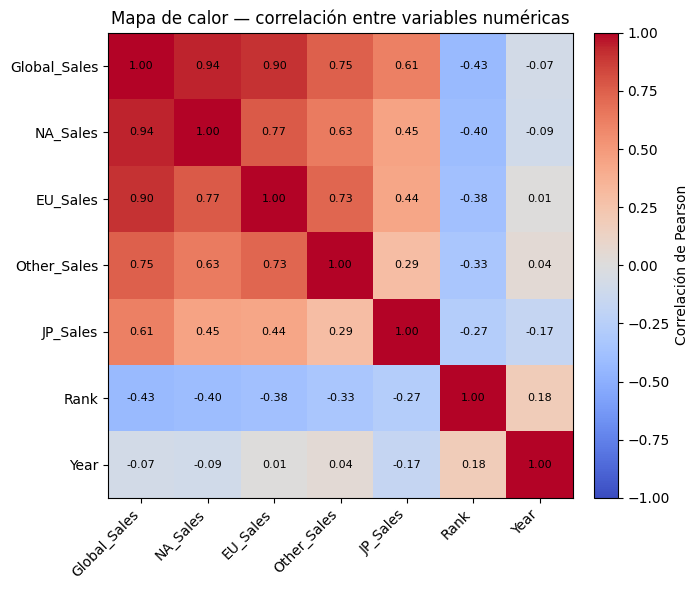

## 5) Balanceo en regresión (bins) y **split** por cédulas
Últimos dos dígitos → promedio **70** ⇒ **Train 70% / Test 30%** (estratificado por **bins** del target).

In [ ]:
def make_bins(y, q=5):
    yb = pd.qcut(y, q=q, duplicates='drop')
    if yb.nunique()<3:
        yb = pd.cut(y, bins=5, include_lowest=True)
    return yb.astype(str)

cedulas = [0000000000, 11111111111, 2222222222, 3333333333]
ult2 = [c%100 for c in cedulas]
prom = int(round(np.mean(ult2)))
train_pct = prom/100.0 if prom>=50 else 1 - (prom/100.0)
test_pct  = 1 - train_pct

X = df_clean[['Platform','Year','Genre','Publisher']].copy()
y = df_clean[target_col].copy()
y_bins = make_bins(y, q=5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_pct, random_state=42, stratify=y_bins
)
display({'train_pct':train_pct,'test_pct':test_pct,'X_train':X_train.shape,'X_test':X_test.shape})

{'train_pct': 0.7,
 'test_pct': 0.30000000000000004,
 'X_train': (11618, 4),
 'X_test': (4980, 4)}

## 6) Preprocesamiento (OHE + escalado) y transformación del **label**
- Numérica: `Year` → imputación mediana + `StandardScaler`
- Categóricas: `OneHotEncoder(sparse=False)` para matrices **densas** (compatibles con Keras)
- Objetivo: entrenamos en **log1p** y predecimos con **expm1** (mitiga outliers)

In [ ]:
numeric_features = ['Year']
categorical_features = ['Platform','Genre','Publisher']

pre = ColumnTransformer(
    transformers=[
        ('num',  SimpleImputer(strategy='median'), numeric_features),
        ('scal', StandardScaler(), numeric_features),  # escalado sobre Year
        ('cat',  OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

X_train_proc = pre.fit_transform(X_train)
X_test_proc  = pre.transform(X_test)
input_dim = X_train_proc.shape[1]
display({'input_dim': input_dim, 'X_train_proc': X_train_proc.shape, 'X_test_proc': X_test_proc.shape})

def y_forward(y):
    return np.log1p(y)
def y_inverse(yhat):
    return np.expm1(yhat)


{'input_dim': 549, 'X_train_proc': (11618, 549), 'X_test_proc': (4980, 549)}

## 7) **MLP (Keras)** — 3 arquitecturas con **logs visibles** (verbose=1)
- `loss='mse'` y métrica `MeanSquaredError()` (MSE)
- `EarlyStopping` + `CSVLogger` para guardar el histórico
- Mostramos **entrenamiento en hold-out** (test antes de CV) con **progreso por época**
- Luego **K-Fold** (menos verboso por claridad)

In [ ]:
def build_mlp(input_dim, layers_cfg=(128,64,32), lr=1e-3, dropout=0.0):
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    for u in layers_cfg:
        model.add(layers.Dense(u, activation='relu'))
        if dropout>0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=[keras.metrics.MeanSquaredError()])
    return model

def train_eval_mlp_holdout(Xp, yp, Xte, yte, layers_cfg, tag, epochs=100, batch_size=64, verbose=1):
    model = build_mlp(Xp.shape[1], layers_cfg)
    log_file = f"mlp_{tag}.csv"
    callbacks=[EarlyStopping(monitor='val_mean_squared_error', patience=10, restore_best_weights=True),
               CSVLogger(log_file, append=False)]
    hist = model.fit(Xp, y_forward(yp), validation_split=0.2, epochs=epochs, batch_size=batch_size,
                     verbose=verbose, callbacks=callbacks)
    y_pred = y_inverse(model.predict(Xte, verbose=0).ravel())
    mse = mean_squared_error(yte, y_pred)
    mae = mean_absolute_error(yte, y_pred)
    r2  = r2_score(yte, y_pred)
    return model, {'modelo':f"MLP_{'x'.join(map(str,layers_cfg))}", 'holdout_mse':mse, 'holdout_mae':mae, 'holdout_r2':r2, 'log_file':log_file}

layers_list = [(64,32),(128,64,32),(256,128,64)]
hold_rows = []
mlp_models = {}
for cfg in layers_list:
    tag = 'x'.join(map(str,cfg))
    model, row = train_eval_mlp_holdout(X_train_proc, y_train, X_test_proc, y_test, cfg, tag, epochs=100, batch_size=64, verbose=1)
    mlp_models[tag] = model
    hold_rows.append(row)
pd.DataFrame(hold_rows)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 328.5977 - mean_squared_error: 328.5977 - val_loss: 0.1516 - val_mean_squared_error: 0.1516
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1698 - mean_squared_error: 0.1698 - val_loss: 0.1502 - val_mean_squared_error: 0.1502
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - val_loss: 0.1569 - val_mean_squared_error: 0.1569
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1453 - val_mean_squared_error: 0.1453
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1348 - val_mean_squared_error: 0.1348
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1522 - mean_squared_error: 0.1522 - val_loss: 0.1370 - val_mean_squared_error: 0.1370
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1494 - mean_squared_error: 0.1494 - val

,modelo,holdout_mse,holdout_mae,holdout_r2,log_file
0,MLP_64x32,2.961828,0.438959,0.050498,mlp_64x32.csv
1,MLP_128x64x32,2.949448,0.443458,0.054466,mlp_128x64x32.csv
2,MLP_256x128x64,2.987876,0.580125,0.042147,mlp_256x128x64.csv


### 7.1) Curvas de aprendizaje (desde los CSVLogger)

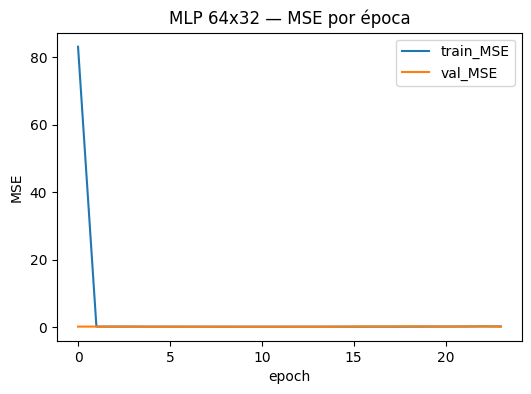

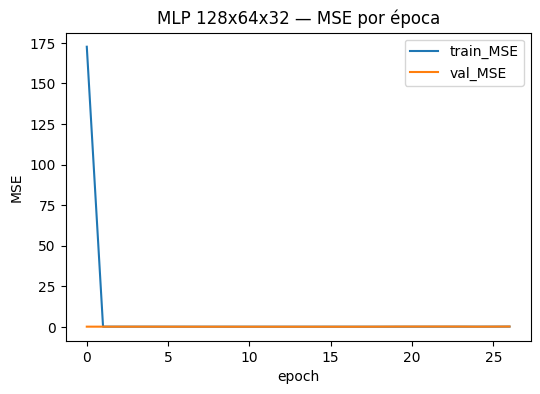

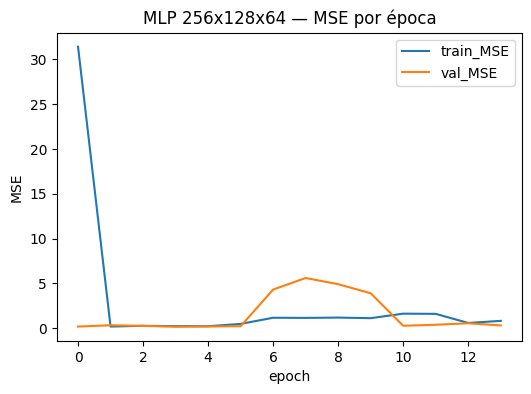

In [ ]:
import pandas as pd

def plot_learning(log_file, title):
    h = pd.read_csv(log_file)
    plt.figure(figsize=(6,4))
    plt.plot(h['epoch'], h['mean_squared_error'], label='train_MSE')
    plt.plot(h['epoch'], h['val_mean_squared_error'], label='val_MSE')
    plt.title(title); plt.xlabel('epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

for cfg in layers_list:
    tag = 'x'.join(map(str,cfg))
    plot_learning(f"mlp_{tag}.csv", f"MLP {tag} — MSE por época")

### 7.2) K-Fold (5) para MLP (resumen)

In [ ]:
def kfold_mlp(Xp, yp, layers_cfg, k=5, epochs=80, batch_size=64, verbose=0):
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    mses, maes, r2s = [], [], []
    for tr, va in kf.split(Xp):
        m = build_mlp(Xp.shape[1], layers_cfg)
        m.fit(Xp[tr], y_forward(yp.iloc[tr]), validation_data=(Xp[va], y_forward(yp.iloc[va])),
              epochs=epochs, batch_size=batch_size, verbose=verbose,
              callbacks=[EarlyStopping(monitor='val_mean_squared_error', patience=8, restore_best_weights=True)])
        y_va_pred = y_inverse(m.predict(Xp[va], verbose=0).ravel())
        mses.append(mean_squared_error(yp.iloc[va], y_va_pred))
        maes.append(mean_absolute_error(yp.iloc[va], y_va_pred))
        r2s.append(r2_score(yp.iloc[va], y_va_pred))
    return np.mean(mses), np.std(mses), np.mean(maes), np.std(maes), np.mean(r2s), np.std(r2s)

mlp_cv_rows = []
for cfg in layers_list:
    m = kfold_mlp(X_train_proc, y_train, cfg, k=5, epochs=80, batch_size=64, verbose=0)
    mlp_cv_rows.append({'modelo':f"MLP_{'x'.join(map(str,cfg))}",
                        'cv_mse_mean':m[0],'cv_mse_std':m[1],'cv_mae_mean':m[2],'cv_mae_std':m[3],'cv_r2_mean':m[4],'cv_r2_std':m[5]})
mlp_cv_df = pd.DataFrame(mlp_cv_rows).copy()
mlp_cv_df["cv_rmse_mean"] = np.sqrt(mlp_cv_df["cv_mse_mean"])
mlp_cv_df = mlp_cv_df[[
    "modelo","cv_mse_mean","cv_rmse_mean","cv_mae_mean","cv_r2_mean",
    "cv_mse_std","cv_mae_std","cv_r2_std"
]]
display(mlp_cv_df)



,modelo,cv_mse_mean,cv_rmse_mean,cv_mae_mean,cv_r2_mean,cv_mse_std,cv_mae_std,cv_r2_std
0,MLP_64x32,1.957176,1.398991,0.455018,0.085550,0.708957,0.043160,0.036024
1,MLP_128x64x32,1.921292,1.386107,0.452928,0.091400,0.603173,0.028560,0.012905
2,MLP_256x128x64,1.971677,1.404164,0.454195,0.070334,0.634637,0.045318,0.030016


## 8) Ensembles: RF / GB / ExtraTrees — hold-out + K-Fold

In [ ]:
def fit_predict_sklearn(model, Xtr, ytr, Xte):
    model.fit(Xtr, np.log1p(ytr))
    yhat = np.expm1(model.predict(Xte).ravel())
    return yhat

rf  = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE)
etr = ExtraTreesRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)

ens_models = [('RandomForest', rf), ('GradientBoosting', gbr), ('ExtraTrees', etr)]

# Hold-out
ens_hold = []
ens_predictions_test = {}
for name, model in ens_models:
    y_pred = fit_predict_sklearn(model, X_train_proc, y_train, X_test_proc)
    ens_predictions_test[name] = y_pred
    ens_hold.append({'modelo':name,
                     'holdout_mse': mean_squared_error(y_test, y_pred),
                     'holdout_mae': mean_absolute_error(y_test, y_pred),
                     'holdout_r2':  r2_score(y_test, y_pred)})
ens_hold_df = pd.DataFrame(ens_hold)
ens_hold_df

,modelo,holdout_mse,holdout_mae,holdout_r2
0,RandomForest,2.855331,0.449570,0.084639
1,GradientBoosting,2.870233,0.440918,0.079861
2,ExtraTrees,3.128851,0.494270,-0.003046


In [ ]:
# K-Fold
def kfold_sklearn(model, Xp, yp, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    mses, maes, r2s = [], [], []
    for tr, va in kf.split(Xp):
        m = model.__class__(**model.get_params())
        m.fit(Xp[tr], np.log1p(yp.iloc[tr]))
        y_va_pred = np.expm1(m.predict(Xp[va]).ravel())
        mses.append(mean_squared_error(yp.iloc[va], y_va_pred))
        maes.append(mean_absolute_error(yp.iloc[va], y_va_pred))
        r2s.append(r2_score(yp.iloc[va], y_va_pred))
    return np.mean(mses), np.std(mses), np.mean(maes), np.std(maes), np.mean(r2s), np.std(r2s)

ens_cv_rows = []
for name, model in ens_models:
    m = kfold_sklearn(model, X_train_proc, y_train, k=5)
    ens_cv_rows.append({'modelo':name,'cv_mse_mean':m[0],'cv_mse_std':m[1],'cv_mae_mean':m[2],'cv_mae_std':m[3],'cv_r2_mean':m[4],'cv_r2_std':m[5]})
pd.DataFrame(ens_cv_rows)

,modelo,cv_mse_mean,cv_mse_std,cv_mae_mean,cv_mae_std,cv_r2_mean,cv_r2_std
0,RandomForest,1.927778,0.602073,0.452561,0.014746,0.088284,0.009829
1,GradientBoosting,1.851264,0.645232,0.432300,0.018751,0.132172,0.027803
2,ExtraTrees,2.293561,0.525597,0.498438,0.013440,-0.107936,0.085207


## 9) Comparativa global (6 modelos) — ordenado por MSE de Test

In [ ]:
mlp_hold_df = pd.DataFrame(hold_rows)
mlp_cv_df   = pd.DataFrame(mlp_cv_rows)
mlp_cv_df["cv_rmse_mean"] = np.sqrt(mlp_cv_df["cv_mse_mean"])
full = (mlp_hold_df.merge(mlp_cv_df, on='modelo', how='left'))
full = pd.concat([full, pd.DataFrame(ens_hold_df).merge(pd.DataFrame(ens_cv_rows), on='modelo', how='left')], ignore_index=True)
full = full.sort_values('holdout_mse')
full

,modelo,holdout_mse,holdout_mae,holdout_r2,log_file,cv_mse_mean,cv_mse_std,cv_mae_mean,cv_mae_std,cv_r2_mean,cv_r2_std,cv_rmse_mean
3,RandomForest,2.855331,0.449570,0.084639,NaN,1.927778,0.602073,0.452561,0.014746,0.088284,0.009829,NaN
4,GradientBoosting,2.870233,0.440918,0.079861,NaN,1.851264,0.645232,0.432300,0.018751,0.132172,0.027803,NaN
1,MLP_128x64x32,2.949448,0.443458,0.054466,mlp_128x64x32.csv,1.921292,0.603173,0.452928,0.028560,0.091400,0.012905,1.386107
0,MLP_64x32,2.961828,0.438959,0.050498,mlp_64x32.csv,1.957176,0.708957,0.455018,0.043160,0.085550,0.036024,1.398991
2,MLP_256x128x64,2.987876,0.580125,0.042147,mlp_256x128x64.csv,1.971677,0.634637,0.454195,0.045318,0.070334,0.030016,1.404164
5,ExtraTrees,3.128851,0.494270,-0.003046,NaN,2.293561,0.525597,0.498438,0.013440,-0.107936,0.085207,NaN


## 10) GridSearchCV (3 configuraciones por ensemble)
Se usa `neg_mean_squared_error` como *scoring*. Reportamos MSE positivo y métricas en Test.

In [ ]:
grids = {
    'RandomForest': {
        'n_estimators': [200, 400, 600],
        'max_depth': [None, 30, 60],
        'min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [2, 3]
    },
    'ExtraTrees': {
        'n_estimators': [200, 400, 600],
        'max_depth': [None, 30, 60],
        'min_samples_leaf': [1, 2]
    }
}

def gridsearch_ensemble(name, base_model, grid, Xp, yp):
    gs = GridSearchCV(base_model, param_grid=grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    gs.fit(Xp, np.log1p(yp))
    best = gs.best_estimator_
    y_pred = np.expm1(best.predict(X_test_proc).ravel())
    row = {
        'modelo': name,
        'best_params': gs.best_params_,
        'best_cv_mse': -gs.best_score_,
        'test_mse': mean_squared_error(y_test, y_pred),
        'test_mae': mean_absolute_error(y_test, y_pred),
        'test_r2':  r2_score(y_test, y_pred)
    }
    return row

grid_rows = []
grid_rows.append(gridsearch_ensemble('RandomForest', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), grids['RandomForest'], X_train_proc, y_train))
grid_rows.append(gridsearch_ensemble('GradientBoosting', GradientBoostingRegressor(random_state=RANDOM_STATE), grids['GradientBoosting'], X_train_proc, y_train))
grid_rows.append(gridsearch_ensemble('ExtraTrees', ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1), grids['ExtraTrees'], X_train_proc, y_train))
grid_df = pd.DataFrame(grid_rows).sort_values('test_mse')
grid_df

,modelo,best_params,best_cv_mse,test_mse,test_mae,test_r2
0,RandomForest,"{'max_depth': 30, 'min_samples_leaf': 2, 'n_es...",0.114368,2.748730,0.436443,0.118813
2,ExtraTrees,"{'max_depth': 30, 'min_samples_leaf': 2, 'n_es...",0.124370,2.780027,0.452308,0.108780
1,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.106625,2.816957,0.432624,0.096941


In [ ]:
import pandas as pd, json, ast
pd.set_option('display.max_colwidth', None)

def to_dict_safe(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str) and x.strip().startswith('{'):
        try:    return ast.literal_eval(x)   # convierte string→dict de forma segura
        except: return x
    return x

tmp = grid_df.copy()
tmp['best_params'] = tmp['best_params'].apply(to_dict_safe)
display(tmp[['modelo','best_params','best_cv_mse','test_mse','test_mae','test_r2']])


,modelo,best_params,best_cv_mse,test_mse,test_mae,test_r2
0,RandomForest,"{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 400}",0.114368,2.748730,0.436443,0.118813
2,ExtraTrees,"{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 600}",0.124370,2.780027,0.452308,0.108780
1,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 400}",0.106625,2.816957,0.432624,0.096941


## (Extra) Baseline — predecir la media
Útil para contexto: si un modelo no mejora a la media, no está aportando.

In [ ]:
y_mean = y_train.mean()
y_pred_base = np.full_like(y_test.values, y_mean)
base_mse = mean_squared_error(y_test, y_pred_base)
base_mae = mean_absolute_error(y_test, y_pred_base)
base_r2  = r2_score(y_test, y_pred_base)
pd.DataFrame([{'modelo':'BaselineMedia','test_mse':base_mse,'test_mae':base_mae,'test_r2':base_r2}])

,modelo,test_mse,test_mae,test_r2
0,BaselineMedia,3.119386,0.592741,-0.000012


## **Probabilidad de que un modelo sea mejor** (Bootstrap de MSE en Test)
Para cada par de modelos A vs. B, comparamos sus **errores al cuadrado** por muestra en Test y hacemos **bootstrap** de índices (p.ej., 2000 réplicas).  
Calculamos \(P(\text{MSE}_A < \text{MSE}_B)\).  
Esto responde a tu pregunta de **“¿con qué probabilidad este modelo es mejor?”** dada la muestra de Test.

In [ ]:
# 1) Obtener predicciones de TODOS los modelos en Test
preds_test = {}
for cfg in [(64,32),(128,64,32),(256,128,64)]:
    tag_key = 'x'.join(map(str,cfg))
    tag = 'MLP_'+tag_key
    model = mlp_models[tag_key]
    preds_test[tag] = y_inverse(model.predict(X_test_proc, verbose=0).ravel())
for name, _ in [('RandomForest', None), ('GradientBoosting', None), ('ExtraTrees', None)]:
    preds_test[name] = ens_predictions_test[name]

# 2) Matriz de errores al cuadrado por muestra
se = {k: (y_test.values - v)**2 for k,v in preds_test.items()}
models_list = list(se.keys())

def win_prob_matrix(se_dict, B=2000, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    keys = list(se_dict.keys())
    n = len(y_test)
    W = np.zeros((len(keys), len(keys)))
    se_stack = np.stack([se_dict[k] for k in keys], axis=0)  # shape: m x n
    for i in range(len(keys)):
        for j in range(len(keys)):
            if i==j:
                W[i,j] = np.nan
                continue
            wins = 0
            for b in range(B):
                idx = rng.integers(0, n, size=n)  # bootstrap indices
                mse_i = se_stack[i, idx].mean()
                mse_j = se_stack[j, idx].mean()
                wins += (mse_i < mse_j)
            W[i,j] = wins / B
    return keys, W

keys, W = win_prob_matrix(se, B=2000, seed=RANDOM_STATE)
winprob_df = pd.DataFrame(W, index=keys, columns=keys)
winprob_df

,MLP_64x32,MLP_128x64x32,MLP_256x128x64,RandomForest,GradientBoosting,ExtraTrees
MLP_64x32,NaN,0.000,0.9995,0.0185,0.0000,0.9625
MLP_128x64x32,1.0000,NaN,1.0000,0.0400,0.0000,0.9655
MLP_256x128x64,0.0005,0.000,NaN,0.0075,0.0000,0.9150
RandomForest,0.9840,0.965,0.9960,NaN,0.5835,1.0000
GradientBoosting,1.0000,1.000,1.0000,0.4215,NaN,0.9945
ExtraTrees,0.0490,0.035,0.0770,0.0000,0.0065,NaN


**Lectura:** `winprob_df.loc[A, B]` ≈ probabilidad de que **A** tenga menor MSE que **B** en Test.

Podemos además calcular el **porcentaje de “victorias”** contra todos (promedio por fila):

In [ ]:
row_means = winprob_df.mean(axis=1, skipna=True).sort_values(ascending=False)
pd.DataFrame({'win_rate_vs_all': row_means})

,win_rate_vs_all
RandomForest,0.9057
GradientBoosting,0.8832
MLP_128x64x32,0.6011
MLP_64x32,0.3961
MLP_256x128x64,0.1846
ExtraTrees,0.0335


# 11) Guardar, cargar y **usar** el modelo ganador
Guardamos el **preprocesador** (`pre`) y el **modelo** que mejor rindió según `full` (holdout MSE).  
Luego mostramos cómo **cargar** esos artefactos en otro entorno y **predecir** ventas (en **millones**).



In [ ]:
# ====== GUARDAR "MEJOR GLOBAL" + "MEJOR MLP" ======
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path

SAVE_DIR = Path('/content')
SAVE_DIR.mkdir(parents=True, exist_ok=True)
sp = lambda name: str(SAVE_DIR / name)

# ---------- 0) Helpers ----------
def build_mlp(input_dim, layers_cfg=(128,64,32), lr=1e-3, dropout=0.0):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    for u in layers_cfg:
        model.add(layers.Dense(int(u), activation='relu'))
        if dropout>0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))  # salida lineal (regresión en log)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=[keras.metrics.MeanSquaredError()])
    return model

def refit_ensemble(name, params=None):
    # Construye y reentrena el ensemble ganador en TODO el TRAIN (en log1p del target)
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
    base = None
    if 'RandomForest' in name:
        base = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif 'GradientBoosting' in name:
        base = GradientBoostingRegressor(random_state=42)
    elif 'ExtraTrees' in name:
        base = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    else:
        raise ValueError(f"No reconozco el ensemble: {name}")
    if params:
        base.set_params(**params)
    base.fit(X_train_proc, np.log1p(y_train))
    return base

def get_best_params_from_grid(model_name):
    # Si tienes grid_df, extrae best_params del modelo correspondiente
    if 'grid_df' in globals():
        row = None
        # busca por coincidencia contenida (p.ej. 'RandomForest' dentro de 'RandomForest')
        candidates = grid_df[grid_df['modelo'].astype(str).str.contains(model_name, case=False, regex=False)]
        if len(candidates)>0:
            row = candidates.sort_values('test_mse').iloc[0]
            return row['best_params'] if 'best_params' in row and isinstance(row['best_params'], (dict,str)) else None
    return None

# ---------- 1) Guardar PREPROCESADOR (común a ambos) ----------
joblib.dump(pre, sp('preprocessor.pkl'))

artifacts = {}

# ---------- 2) MEJOR GLOBAL por holdout_mse (tabla 'full') ----------
assert 'full' in globals(), "No encuentro la tabla 'full'. Ejecútala antes."
best_global = full.sort_values('holdout_mse').iloc[0]
best_name = str(best_global['modelo'])
print('[Winner Global] por holdout_mse:', best_name)

if best_name.startswith('MLP_'):
    # Recuperar o reentrenar MLP ganador global
    key = best_name.replace('MLP_','').replace('×','x').replace('X','x')
    if 'mlp_models' in globals() and key in mlp_models:
        best_global_model = mlp_models[key]
        print('Usando MLP ganador ya entrenado en memoria:', key)
    else:
        layers_cfg = tuple(map(int, key.split('x')))
        print('Reentrenando MLP ganador con capas:', layers_cfg)
        best_global_model = build_mlp(X_train_proc.shape[1], layers_cfg)
        from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
        cb = [EarlyStopping(monitor='val_mean_squared_error', patience=10, restore_best_weights=True),
              CSVLogger(sp(f"mlp_{key}_winner_retrain.csv"), append=False)]
        best_global_model.fit(X_train_proc, np.log1p(y_train),
                              validation_split=0.2, epochs=100, batch_size=64,
                              verbose=1, callbacks=cb)
    best_global_path = sp('model_winner.keras')
    best_global_model.save(best_global_path)
    winner_meta = {'winner': best_name, 'type': 'keras'}
else:
    # Ensemble: intenta usar hiperparámetros del grid si existen
    bp = get_best_params_from_grid(best_name)
    if isinstance(bp, str):
        import ast
        try: bp = ast.literal_eval(bp)
        except: bp = None
    print(f"Hiperparámetros usados para {best_name}:", bp if bp else "(por defecto)")
    best_global_model = refit_ensemble(best_name, params=bp)
    best_global_path = sp('model_winner.pkl')
    joblib.dump(best_global_model, best_global_path)
    winner_meta = {'winner': best_name, 'type': 'sklearn'}

with open(sp('model_meta.json'),'w', encoding='utf-8') as f:
    json.dump(winner_meta, f, ensure_ascii=False, indent=2)
artifacts['winner'] = os.path.basename(best_global_path)

# ---------- 3) MEJOR MLP (independiente del ganador global) ----------
mlp_mask = full['modelo'].astype(str).str.startswith('MLP_')
assert mlp_mask.any(), "No hay filas MLP_ en 'full'."
best_mlp_row = full[mlp_mask].sort_values('holdout_mse').iloc[0]
best_mlp_name = str(best_mlp_row['modelo'])
mlp_key = best_mlp_name.replace('MLP_','').replace('×','x').replace('X','x')
print('[Best MLP] por holdout_mse:', best_mlp_name)

if 'mlp_models' in globals() and mlp_key in mlp_models:
    best_mlp_model = mlp_models[mlp_key]
    print('Usando MLP ya entrenado en memoria:', mlp_key)
else:
    layers_cfg = tuple(map(int, mlp_key.split('x')))
    print('Reentrenando mejor MLP con capas:', layers_cfg)
    best_mlp_model = build_mlp(X_train_proc.shape[1], layers_cfg)
    from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
    cb = [EarlyStopping(monitor='val_mean_squared_error', patience=10, restore_best_weights=True),
          CSVLogger(sp(f"mlp_{mlp_key}_best_retrain.csv"), append=False)]
    best_mlp_model.fit(X_train_proc, np.log1p(y_train),
                       validation_split=0.2, epochs=100, batch_size=64,
                       verbose=1, callbacks=cb)

mlp_best_path = sp('mlp_best.keras')
best_mlp_model.save(mlp_best_path)
with open(sp('mlp_meta.json'),'w', encoding='utf-8') as f:
    json.dump({'winner': best_mlp_name, 'type':'keras'}, f, ensure_ascii=False, indent=2)
artifacts['mlp'] = os.path.basename(mlp_best_path)

# ---------- 4) Resumen de archivos ----------
print('\n Artefactos guardados en', SAVE_DIR)
for p in sorted(SAVE_DIR.iterdir()):
    if p.suffix in ('.pkl','.keras','.json','.csv'):
        print(' -', p.name)


[Winner Global] por holdout_mse: RandomForest
Hiperparámetros usados para RandomForest: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 400}
[Best MLP] por holdout_mse: MLP_128x64x32
Usando MLP ya entrenado en memoria: 128x64x32

 Artefactos guardados en /content
 - mlp_128x64x32.csv
 - mlp_256x128x64.csv
 - mlp_64x32.csv
 - mlp_best.keras
 - mlp_meta.json
 - model_meta.json
 - model_winner.pkl
 - preprocessor.pkl
 - vgsales.csv


In [ ]:
# === PREDICCIONES CON WINNER (RF) Y MLP, EN TABLA ===
import joblib, json, numpy as np, pandas as pd, os
import tensorflow as tf
from pathlib import Path

SAVE_DIR = Path('/content')
sp = lambda name: str(SAVE_DIR / name)

# 1) Cargar preprocesador y modelos
pre = joblib.load(sp('preprocessor.pkl'))

def load_model(which='winner'):
    if which == 'winner':
        meta = json.load(open(sp('model_meta.json')))
        if meta['type'] == 'keras':
            model = tf.keras.models.load_model(sp('model_winner.keras'))
        else:
            model = joblib.load(sp('model_winner.pkl'))
    else:
        meta = json.load(open(sp('mlp_meta.json')))
        model = tf.keras.models.load_model(sp('mlp_best.keras'))
    return model, meta

def predict_df(df_like: pd.DataFrame, which='winner'):
    model, meta = load_model(which=which)
    Xp = pre.transform(df_like)
    ylog = model.predict(Xp) if meta['type'] == 'keras' else model.predict(Xp)
    y = np.expm1(np.asarray(ylog).ravel())  # ventas en millones
    return y

# 2) Tus ejemplos
df_new = pd.DataFrame([
    {"Platform":"X360","Year":2011,"Genre":"Sports", "Publisher":"Electronic Arts"},
    {"Platform":"Wii", "Year":2009,"Genre":"Racing", "Publisher":"Nintendo"},
    {"Platform":"PS3", "Year":2012,"Genre":"Shooter","Publisher":"Unknown"},
    {"Platform":"PS2", "Year":2002,"Genre":"Shooter","Publisher":"Rockstar Games"},
    {"Platform":"Wii", "Year":2006,"Genre":"Sports","Publisher":"Nintendo"},
])

# 3) Predecir con ambos modelos
pred_winner = predict_df(df_new, which='winner')
pred_mlp    = predict_df(df_new, which='mlp')

# 4) Armar tabla de salida
out = df_new.copy()
out['pred_winner_M'] = np.round(pred_winner, 3)             # millones
out['pred_mlp_M']    = np.round(pred_mlp, 3)                # millones
out['diff_M']        = np.round(out['pred_winner_M'] - out['pred_mlp_M'], 3)
out['winner_copies'] = (out['pred_winner_M'] * 1_000_000).round().astype(int)
out['mlp_copies']    = (out['pred_mlp_M'] * 1_000_000).round().astype(int)

# 5) Mostrar y guardar
print(out)
csv_path = sp('predicciones_demo.csv')
out.to_csv(csv_path, index=False, encoding='utf-8')
print("\nCSV guardado en:", csv_path)

# 6) Si también quieres ver los primeros valores rápido:
print("\nPrimer ejemplo -> Winner:", float(pred_winner[0]), "M | MLP:", float(pred_mlp[0]), "M")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
  Platform  Year    Genre        Publisher  pred_winner_M  pred_mlp_M  diff_M  \
0     X360  2011   Sports  Electronic Arts          1.031       0.590   0.441   
1      Wii  2009   Racing         Nintendo          1.212       1.055   0.157   
2      PS3  2012  Shooter          Unknown          0.294       0.341  -0.047   
3      PS2  2002  Shooter   Rockstar Games          0.296       0.469  -0.173   
4      Wii  2006   Sports         Nintendo          2.447       1.121   1.326   

   winner_copies  mlp_copies  
0        1031000      590000  
1        1212000     1055000  
2         294000      341000  
3         296000      469000  
4        2447000     1121000  

CSV guardado en: /content/predicciones_demo.csv

Primer ejemplo -> Winner: 1.0305546344674084 M | MLP: 0.5903526544570923 M
